In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import datasets
from torchvision import transforms
from torchvision.utils import save_image
from IPython.display import Image
from IPython.core.display import Image,display
import numpy as np
from PIL import Image
from tqdm import tqdm
import random
import matplotlib.pyplot as plt
to_image = transforms.ToPILImage()
%load_ext autoreload
%autoreload 2

In [3]:
dev = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


device(type='cuda')

In [25]:
def load_pictures():
    # dataset = datasets(root='/home/emile/Documents/Code/RL_car/train_data', transform=Picture())
    # dataset = datasets.ImageFolder(root='/home/emile/Documents/Code/RL_car/train_data', transform=transforms.Compose([
    #     transforms.ToTensor(),
    # ]))
    pic_dir = 'data/train/'

    file_name = ".jpg"
    #num_file = sum(os.path.isfile(os.path.join(pic_dir, name)) for name in os.listdir(pic_dir))
    num_file = 7000
    ans = []
    for index in tqdm(range(num_file)):
        path = pic_dir + "/" + str(index) + file_name
        img = np.array(Image.open(path).resize((160, 120)).crop((0, 40, 160, 120)))
        im = torch.from_numpy(img.reshape((1, 80, 160, 3))).to(dev).permute(0, 3, 1, 2).float().to(dev)
        ans.append(im/255.0)
    # ans = torch.utils.data.DataLoader(ans, batch_size=64, shuffle=True, num_workers=2, pin_memory=True)
    # dataloader = torch.utils.data.DataLoader(dataset, batch_size=64, shuffle=True, num_workers=2, pin_memory=True)
    random.shuffle(ans)
    return ans

In [26]:
def reparameterize(means, logvar):
    stds = (0.5*logvar).exp()
    noises = torch.randn_like(means)
    acts = means + noises * stds
    return acts


class Flatten(nn.Module):
    def forward(self, inputs):
        return inputs.contiguous().view(inputs.size(0), -1)


class UnFlatten(nn.Module):
    def forward(self, inputs, size=256):
        ans = inputs.view(inputs.size(0), size, 3, 8)
        return ans

In [27]:
class VAE(nn.Module):
    def __init__(self, image_channels=3, h_dim=6144, z_dim=32):
        super(VAE, self).__init__()
        self.z_dim = z_dim
        self.encoder = nn.Sequential(
            nn.Conv2d(image_channels, 32, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=4, stride=2),
            nn.ReLU(),
            Flatten()
        ).to(dev)

        self.fc1 = nn.Linear(h_dim, z_dim).to(dev)
        self.fc2 = nn.Linear(h_dim, z_dim).to(dev)
        self.fc3 = nn.Linear(z_dim, h_dim).to(dev)

        self.decoder = nn.Sequential(
            UnFlatten(),
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=5, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(32, image_channels, kernel_size=4, stride=2),
            nn.Sigmoid(),
        ).to(dev)

    def reparameterize(self, mu, logvar):
        std = logvar.mul(0.5).exp_()
        esp = torch.randn(*mu.size()).to(dev)
        z = mu + std * esp
        return z

    def bottleneck(self, h):
        mu, logvar = self.fc1(h), F.softplus(self.fc2(h))
        z = self.reparameterize(mu, logvar)
        return z, mu, logvar

    def encode(self, x):
        h = self.encoder(x)
        z, mu, logvar = self.bottleneck(h)
        return z, mu, logvar

    def decode(self, z):
        z = self.fc3(z)
        z = self.decoder(z)
        return z

    def forward(self, x):
        z, mu, logvar = self.encode(x)
        r_image = self.decode(z)
        return r_image, mu, logvar, z

    def loss_fn(self, images, r_image, mean, logvar):
        KL = -0.5 * torch.sum((1 + logvar - mean.pow(2) - logvar.exp()), dim=0)
        KL = torch.mean(KL)
        r_image = r_image.contiguous().view(-1, 38400)
        images = images.contiguous().view(-1, 38400)
        r_image_loss = F.binary_cross_entropy(r_image, images, reduction='mean')  # size_average=False)
        # print("loss reconst {}".format(r_image_loss.clone().cpu().detach().numpy()))
        # print("loss KL {}".format(KL.clone().cpu().detach().numpy()))
        loss = r_image_loss + 5.0 * KL
        # print("loss {}".format(loss.clone().cpu().detach().numpy()))
        return loss

    def evaluate(self, image):
        plt.ion()
        r_image, mean, log_var, z = self.forward(image)
        pre_im = to_image(image.clone().detach().cpu().squeeze(0))
        im_now = to_image(r_image.clone().detach().cpu().squeeze(0))
        z = to_image(z.clone().detach().cpu())
        plt.imshow(pre_im)
        plt.pause(0.1)
        plt.imshow(im_now)
        plt.pause(0.1)
        plt.imshow(z)
        plt.pause(0.1)
        plt.figure()

class VAE(nn.Module):
    def __init__(self, image_channels=3, h_dim=6144, z_dim=32):
        super(VAE, self).__init__()
        self.z_dim = z_dim
        self.encoder = nn.Sequential(
            nn.Conv2d(image_channels, 32, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=4, stride=2),
            nn.ReLU(),
            Flatten()
        ).to(dev)

        self.fc1 = nn.Linear(h_dim, z_dim).to(dev)
        self.fc2 = nn.Linear(h_dim, z_dim).to(dev)
        self.fc3 = nn.Linear(z_dim, h_dim).to(dev)

        self.decoder = nn.Sequential(
            UnFlatten(),
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=5, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(32, image_channels, kernel_size=4, stride=2),
            nn.Sigmoid(),
        ).to(dev)

    def reparameterize(self, mu, logvar):
        std = logvar.mul(0.5).exp_()
        esp = torch.randn(*mu.size()).to(dev)
        z = mu + std * esp
        return z

    def bottleneck(self, h):
        mu, logvar = self.fc1(h), F.softplus(self.fc2(h))
        z = self.reparameterize(mu, logvar)
        return z, mu, logvar

    def encode(self, x):
        h = self.encoder(x)
        z, mu, logvar = self.bottleneck(h)
        return z, mu, logvar

    def decode(self, z):
        z = self.fc3(z)
        z = self.decoder(z)
        return z

    def forward(self, x):
        z, mu, logvar = self.encode(x)
        r_image = self.decode(z)
        return r_image, mu, logvar, z

    def loss_fn(self, images, r_image, mean, logvar):
        KL = -0.5 * torch.sum((1 + logvar - mean.pow(2) - logvar.exp()), dim=0)
        KL = torch.mean(KL)
        r_image = r_image.contiguous().view(-1, 38400)
        images = images.contiguous().view(-1, 38400)
        r_image_loss = F.binary_cross_entropy(r_image, images, reduction='mean')  # size_average=False)
        # print("loss reconst {}".format(r_image_loss.clone().cpu().detach().numpy()))
        # print("loss KL {}".format(KL.clone().cpu().detach().numpy()))
        loss = r_image_loss + 5.0 * KL
        # print("loss {}".format(loss.clone().cpu().detach().numpy()))
        return loss

    def evaluate(self, image):
        plt.ion()
        r_image, mean, log_var, z = self.forward(image)
        pre_im = to_image(image.clone().detach().cpu().squeeze(0))
        im_now = to_image(r_image.clone().detach().cpu().squeeze(0))
        #z = to_image(z.clone().detach().cpu())
        plt.imshow(pre_im)
        plt.pause(0.1)
        plt.imshow(im_now)
        plt.pause(0.1)
        #plt.imshow(z)
        plt.pause(0.1)
        plt.figure()

In [28]:
def train_vae(vae, epochs, train_datas):
    optimizer = torch.optim.Adam(vae.parameters(), lr=1e-3)
    vae.train()
    flag = False
    for epoch in range(epochs):
        losses = []
        tmp = 0
        for data in tqdm(train_datas):
            tmp += 1
            images = data.to(dev)
            # if not flag:
            #     vae.evaluate(images)
            #     flag = True
            r_images, means, log_var, zs = vae(images)
            if tmp == 1:
                loss = vae.loss_fn(images, r_images, means, log_var).to(dev)
            else:
                loss += vae.loss_fn(images, r_images, means, log_var).to(dev)
            if (tmp//6) == 0:
                loss = loss.mean()
                loss.backward()
                optimizer.step()
                optimizer.zero_grad()
                tmp = 0
                losses.append(loss.clone().cpu().detach().numpy())
        print("epoch{}: average loss {}".format(epoch, np.array(losses).mean()))
        vae.evaluate(random.choice(train_datas))
        torch.save(vae.cpu().state_dict(), './vae.pth')
        vae.to(dev)
        flag = False



In [29]:
def main():
    vae = VAE().to(device)
    pics = load_pictures()
    train_vae(vae, 50, pics)


100%|██████████████████████████████████████████████████████████████████████████████| 7000/7000 [02:10<00:00, 53.70it/s]


epoch0: average loss 0.6759513020515442


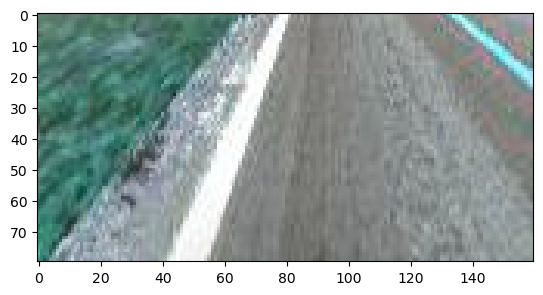

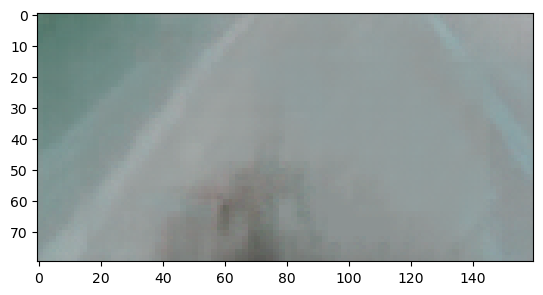

100%|██████████████████████████████████████████████████████████████████████████████| 7000/7000 [02:10<00:00, 53.66it/s]

epoch1: average loss 0.6745703220367432


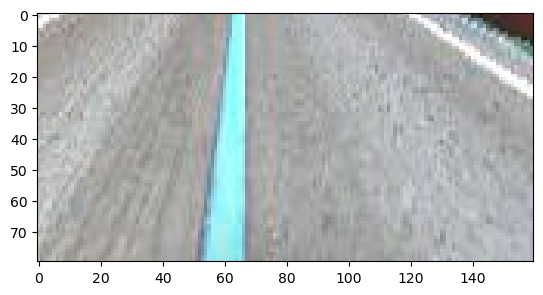

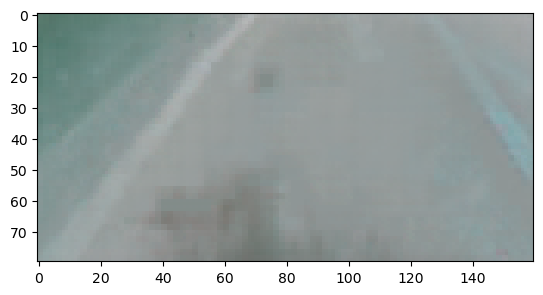

  3%|██▌                                                                            | 223/7000 [00:04<02:07, 53.34it/s]


KeyboardInterrupt: 

<Figure size 640x480 with 0 Axes>

In [30]:
if __name__ == "__main__":
    main()

In [ ]:
vae = VAE().to(device)
pics = load_pictures()
train_vae(vae, 50, pics)

In [14]:
vae = VAE().to(device)

In [15]:
pics = load_pictures()

100%|██████████| 1000/1000 [00:00<00:00, 1146.46it/s]


In [16]:
model_path = 'vae.pth'
vae.load_state_dict(torch.load(model_path))

<All keys matched successfully>

20000
313


313it [01:23,  3.73it/s]

EPOCH: 1 loss: 1587700.75
kl:814.0504150390625 re:771937.625


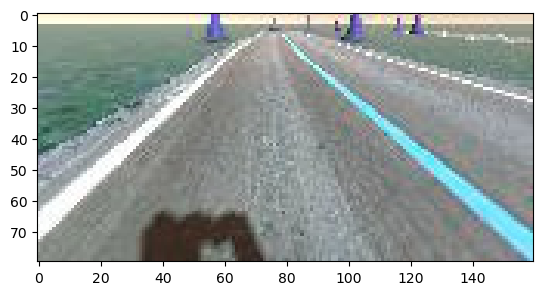

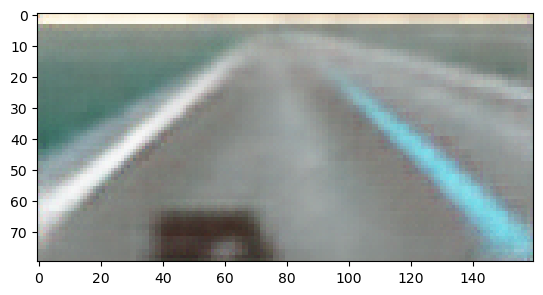

313it [01:23,  3.75it/s]


EPOCH: 2 loss: 1555125.25
kl:750.275146484375 re:776154.625


313it [01:23,  3.74it/s]


EPOCH: 3 loss: 1549188.25
kl:902.0338134765625 re:770856.375


313it [01:23,  3.74it/s]


EPOCH: 4 loss: 1546014.875
kl:856.3801879882812 re:768777.5


313it [01:23,  3.73it/s]


EPOCH: 5 loss: 1544105.125
kl:811.3734130859375 re:765084.0


313it [01:23,  3.74it/s]

EPOCH: 6 loss: 1542712.125
kl:947.4691162109375 re:771694.625


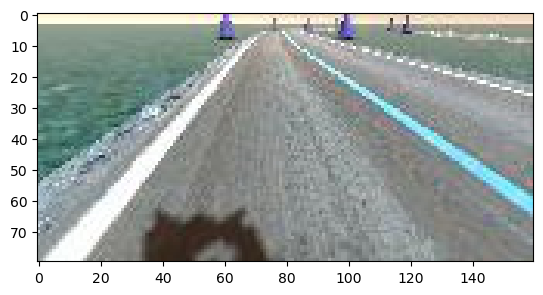

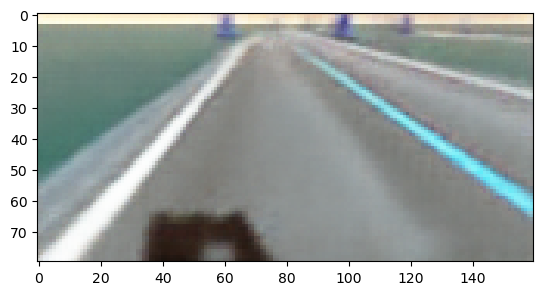

313it [01:23,  3.74it/s]


EPOCH: 7 loss: 1541608.125
kl:934.685546875 re:764557.8125


313it [01:23,  3.74it/s]


EPOCH: 8 loss: 1540672.875
kl:900.0076904296875 re:770146.0


313it [01:23,  3.75it/s]


EPOCH: 9 loss: 1540094.75
kl:968.257080078125 re:768412.4375


313it [01:23,  3.75it/s]


EPOCH: 10 loss: 1539370.125
kl:983.9310302734375 re:767375.1875


313it [01:23,  3.75it/s]

EPOCH: 11 loss: 1538695.5
kl:945.2166748046875 re:769281.375


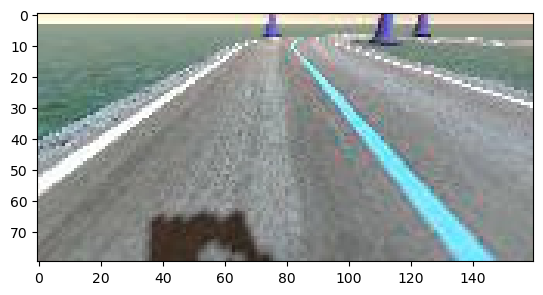

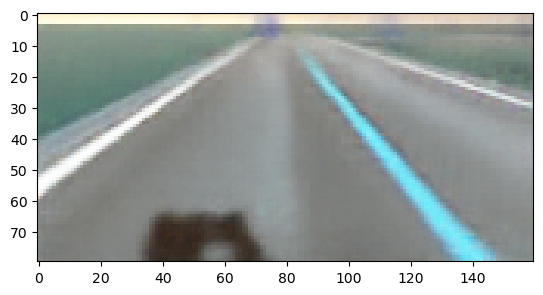

313it [01:23,  3.75it/s]


EPOCH: 12 loss: 1538382.375
kl:934.4872436523438 re:758764.0625


313it [01:23,  3.75it/s]


EPOCH: 13 loss: 1538025.125
kl:837.174560546875 re:765112.6875


313it [01:23,  3.74it/s]


EPOCH: 14 loss: 1537519.625
kl:923.3126220703125 re:765895.1875


313it [01:23,  3.73it/s]


EPOCH: 15 loss: 1537235.375
kl:954.91015625 re:764930.3125


313it [01:23,  3.73it/s]

EPOCH: 16 loss: 1536926.875
kl:940.6207275390625 re:765382.875


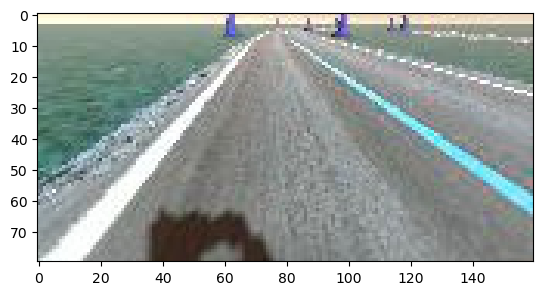

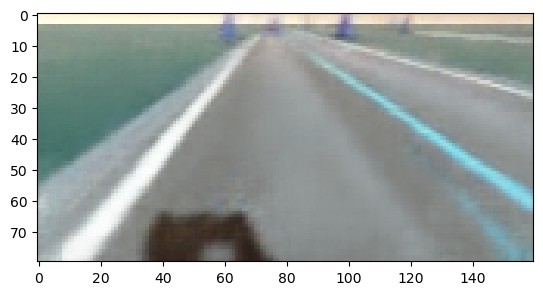

313it [01:23,  3.73it/s]


EPOCH: 17 loss: 1536555.5
kl:1065.623046875 re:758560.0


313it [01:23,  3.73it/s]


EPOCH: 18 loss: 1536394.875
kl:1060.323974609375 re:759701.375


313it [01:23,  3.73it/s]


EPOCH: 19 loss: 1536294.0
kl:825.5457763671875 re:769129.875


313it [01:23,  3.74it/s]


EPOCH: 20 loss: 1535993.5
kl:985.9180908203125 re:769650.125


313it [01:23,  3.74it/s]

EPOCH: 21 loss: 1535766.25
kl:874.0202026367188 re:763413.0625


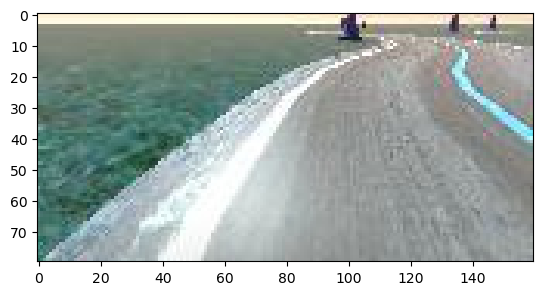

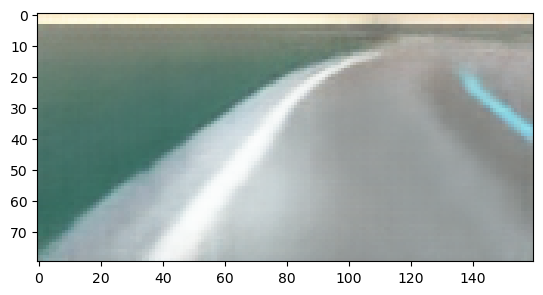

313it [01:23,  3.74it/s]


EPOCH: 22 loss: 1535548.875
kl:891.5184326171875 re:765637.625


313it [01:23,  3.73it/s]


EPOCH: 23 loss: 1535413.125
kl:925.2144775390625 re:766747.75


313it [01:23,  3.73it/s]


EPOCH: 24 loss: 1535270.0
kl:983.8424682617188 re:763627.0


313it [01:23,  3.74it/s]


EPOCH: 25 loss: 1535088.5
kl:882.7622680664062 re:763389.25


313it [01:23,  3.74it/s]

EPOCH: 26 loss: 1534982.375
kl:999.990478515625 re:756870.75


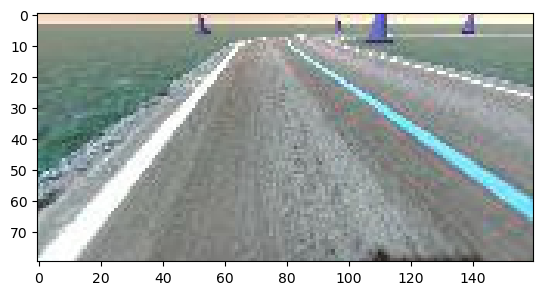

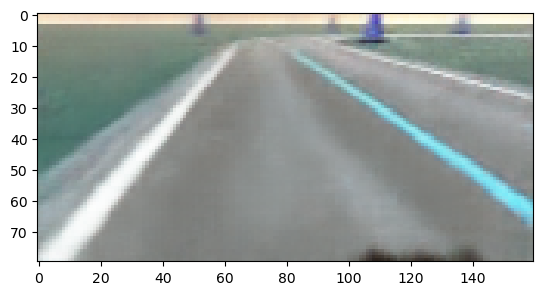

313it [01:23,  3.74it/s]


EPOCH: 27 loss: 1534705.875
kl:796.111572265625 re:768313.0625


313it [01:23,  3.74it/s]


EPOCH: 28 loss: 1534626.75
kl:806.404052734375 re:766401.25


313it [01:23,  3.74it/s]


EPOCH: 29 loss: 1534605.5
kl:961.0101928710938 re:766380.25


313it [01:23,  3.74it/s]


EPOCH: 30 loss: 1534240.5
kl:856.957275390625 re:763732.6875


313it [01:23,  3.74it/s]

EPOCH: 31 loss: 1534199.625
kl:951.140869140625 re:762558.25


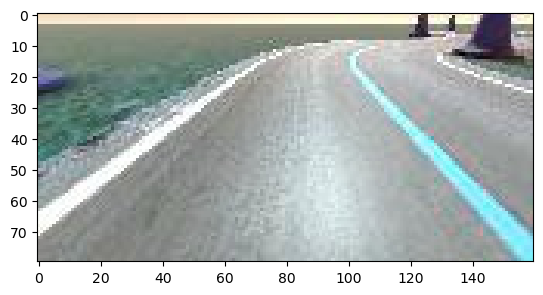

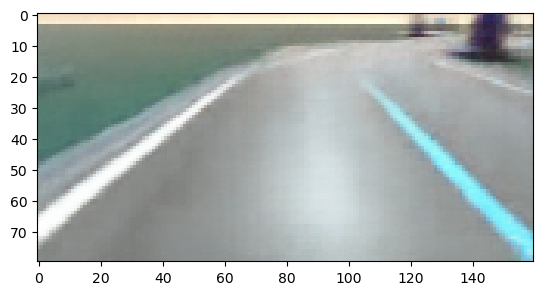

313it [01:23,  3.74it/s]


EPOCH: 32 loss: 1534234.875
kl:856.465576171875 re:758588.6875


313it [01:23,  3.74it/s]


EPOCH: 33 loss: 1533997.25
kl:882.0134887695312 re:757773.6875


313it [01:23,  3.74it/s]


EPOCH: 34 loss: 1533956.75
kl:854.2974243164062 re:768665.75


313it [01:23,  3.74it/s]


EPOCH: 35 loss: 1533927.0
kl:933.3696899414062 re:754545.375


313it [01:23,  3.74it/s]

EPOCH: 36 loss: 1533820.0
kl:949.642578125 re:767049.6875


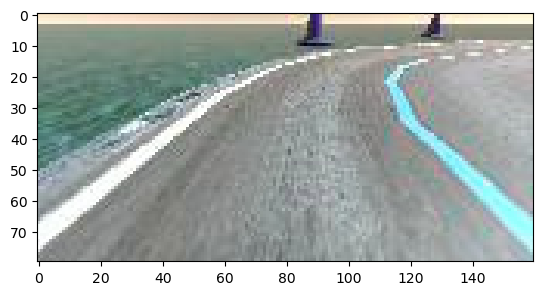

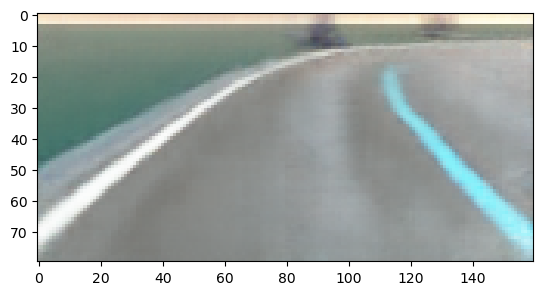

313it [01:23,  3.74it/s]


EPOCH: 37 loss: 1533589.5
kl:850.875732421875 re:761979.1875


313it [01:23,  3.74it/s]


EPOCH: 38 loss: 1533497.25
kl:977.5968627929688 re:764352.125


313it [01:23,  3.74it/s]


EPOCH: 39 loss: 1533526.75
kl:826.759765625 re:759967.5


313it [01:23,  3.74it/s]


EPOCH: 40 loss: 1533459.375
kl:875.1832275390625 re:763710.875


313it [01:23,  3.74it/s]

EPOCH: 41 loss: 1533342.875
kl:896.1417236328125 re:762704.3125


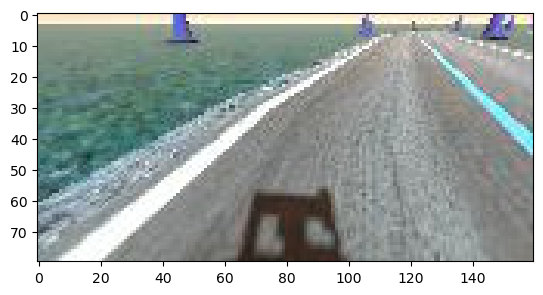

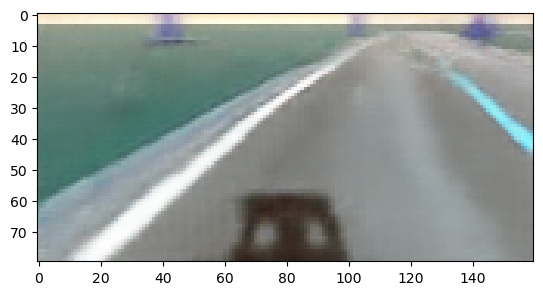

313it [01:23,  3.74it/s]


EPOCH: 42 loss: 1533239.875
kl:840.1387939453125 re:762038.625


313it [01:23,  3.74it/s]


EPOCH: 43 loss: 1533157.625
kl:981.671142578125 re:760901.6875


313it [01:23,  3.74it/s]


EPOCH: 44 loss: 1533104.875
kl:889.67724609375 re:764885.125


313it [01:23,  3.74it/s]


EPOCH: 45 loss: 1532946.0
kl:846.3709716796875 re:762935.5


313it [01:23,  3.74it/s]

EPOCH: 46 loss: 1532927.125
kl:876.3543701171875 re:761430.125


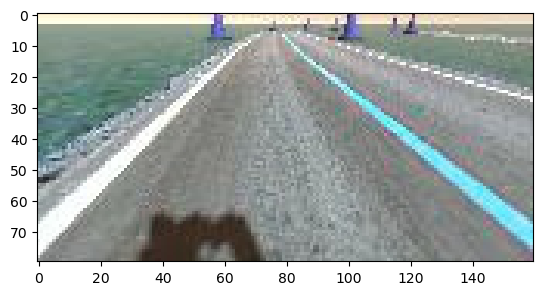

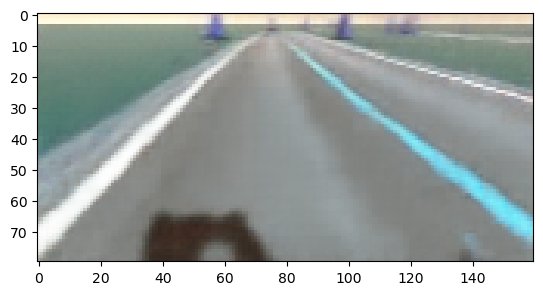

313it [01:23,  3.74it/s]


EPOCH: 47 loss: 1532811.25
kl:902.5238037109375 re:762350.6875


313it [01:23,  3.74it/s]


EPOCH: 48 loss: 1532901.375
kl:962.753662109375 re:756117.9375


313it [01:23,  3.73it/s]


EPOCH: 49 loss: 1532673.625
kl:868.0858764648438 re:757017.75


313it [01:23,  3.74it/s]


EPOCH: 50 loss: 1532673.375
kl:754.8884887695312 re:762259.5


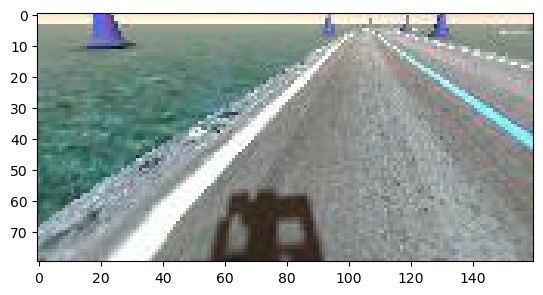

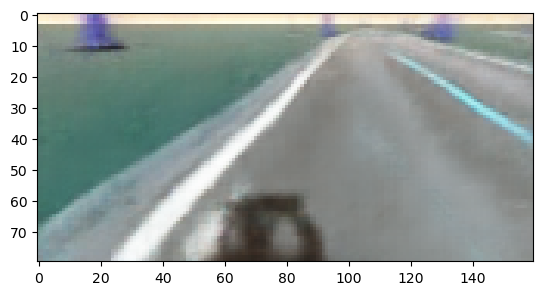

<Figure size 640x480 with 0 Axes>

In [4]:
import numpy as np
import torch
from torch.nn import functional as F
import torch.nn as nn
import math
import os
from PIL import Image
import PIL
from tqdm import tqdm
from torchvision import datasets, transforms
import glob
import random
import matplotlib.pyplot as plt
dev = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
to_image = transforms.ToPILImage()


def load_pictures():
    bs = 64
    dataset = datasets.ImageFolder(root='./data', transform=transforms.Compose([
        transforms.ToTensor(),
    ]))
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=bs, shuffle=True,num_workers=2, pin_memory=True)
    print(len(dataset.imgs)) 
    print(len(dataloader))
    return dataloader



def reparameterize(means, logvar):
    stds = (0.5*logvar).exp()
    noises = torch.randn_like(means)
    acts = means + noises * stds
    return acts


class Flatten(nn.Module):
    def forward(self, inputs):
        return inputs.contiguous().view(inputs.size(0), -1)


class UnFlatten(nn.Module):
    def forward(self, inputs, size=256):
        ans = inputs.view(inputs.size(0), size, 3, 8)
        
        return ans


class VAE(nn.Module):
    def __init__(self, image_channels=3, h_dim=6144, z_dim=128):
        super(VAE, self).__init__()
        self.z_dim = z_dim
        self.encoder = nn.Sequential(
            nn.Conv2d(image_channels, 32, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=4, stride=2),
            nn.ReLU(),
            Flatten()
        ).to(dev)

        self.fc1 = nn.Linear(h_dim, z_dim).to(dev)
        self.fc2 = nn.Linear(h_dim, z_dim).to(dev)
        self.fc3 = nn.Linear(z_dim, h_dim).to(dev)

        self.decoder = nn.Sequential(
            UnFlatten(),
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=5, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(32, image_channels, kernel_size=4, stride=2),
            nn.Sigmoid(),
        ).to(dev)

    def reparameterize(self, mu, logvar):
        std = logvar.mul(0.5).exp_()
        esp = torch.randn(*mu.size()).to(dev)
        z = mu + std * esp
        return z

    def bottleneck(self, h):
        mu, logvar = self.fc1(h), F.softplus(self.fc2(h))
        z = self.reparameterize(mu, logvar)
        return z, mu, logvar

    def encode(self, x):
        h = self.encoder(x)
        z, mu, logvar = self.bottleneck(h)
        return z, mu, logvar

    def decode(self, z):
        z = self.fc3(z)
        z = self.decoder(z)
        return z

    def forward(self, x):
        z, mu, logvar = self.encode(x)
        r_image = self.decode(z)
        return r_image, mu, logvar, z

    def loss_fn(self, images, r_image, mean, logvar ,real=False):
        KL = -0.5 * torch.sum(1 + logvar - mean**2 - torch.exp(logvar))
        if real :
            KL = torch.mean(KL)

        r_image = r_image.contiguous().view(-1, 38400)
        images = images.contiguous().view(-1, 38400)
        r_image_loss = F.binary_cross_entropy(r_image, images, reduction='sum') 
        loss = r_image_loss+ 5.0 * KL 
        return loss,KL,r_image_loss

    def evaluate(self, image,epoch,output_dir):
        plt.ion()
        r_image, mean, log_var, z = self.forward(image)
        pre_im = to_image(image[0].clone().detach().cpu().squeeze(0))
        im_now = to_image(r_image[0].clone().detach().cpu().squeeze(0))
        
        
        #z = to_image([z[0]].clone().detach().cpu())
        plt.imshow(pre_im)
        #plt.imsave(f'{output_dir}/original_{epoch}.png',pre_im)
        plt.pause(0.1)
        plt.imshow(im_now)
        #plt.imsave(f'{output_dir}/Generate_{epoch}.png',im_now)
        plt.pause(0.1)
       # plt.imshow(z)
        #plt.pause(0.1)
        plt.figure()
        



def train_vae(vae, epochs, train_datas,output_dir,real):
    optimizer = torch.optim.Adam(vae.parameters(), lr=1e-3)
    vae.train()
    flag = False
    for epoch in range(epochs):
        losses = []
        tmp = 0
        for idx, (images, _) in tqdm(enumerate(train_datas)):
            
            images = images.to(dev)
            optimizer.zero_grad()
   
            recon_images, mu, logvar, z = vae(images)
            
            loss,kl,re = vae.loss_fn(images, recon_images, mu, logvar,real)
            loss.backward()
            optimizer.step()
            losses.append(loss.cpu().detach().numpy())
            
        print("EPOCH: {} loss: {}".format(epoch+1, np.average(losses)))
        print(f'kl:{kl} re:{re}')

        
        if epoch%5==0:
            vae.evaluate(images,epoch,output_dir)
        torch.save(vae.cpu().state_dict(), f'{output_dir}/vae_generated_track128.pth')
        vae.to(dev)
        flag = False
        
    vae.evaluate(images,epoch,output_dir)





def main():
    output_dir='./'
    real=False
    vae = VAE().to(dev)
    pics = load_pictures()
    train_vae(vae, 50, pics,output_dir,real)

   

if __name__ == "__main__":
    main()